In [20]:
import requests
import pandas as pd

from barentswatch.credentials import config
from barentswatch.authentication import get_token

In [21]:

import warnings
from pprintpp import pprint
warnings.simplefilter(action='ignore', category=FutureWarning)

###### Using API to get data

Link to ApiDocs: https://www.barentswatch.no/bwapi/openapi/index.html?urls.primaryName=Fishhealth%20API

In [22]:
from functions import get_week_summary

In [23]:
token = get_token()
weeksummary= get_week_summary(token,'2017','45')
type(weeksummary)

Token request successful


dict

##### Storing information from the entire year in table

In [24]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [ ]:
from cassandra.cluster import Cluster
from cassandra.query import SimpleStatement

# Establish a connection to the Cassandra cluster
cluster = Cluster(['127.0.0.1'])  # assuming Cassandra is running on localhost
session = cluster.connect()

session.set_keyspace('fish_data')

table_creation_query = """
    CREATE TABLE IF NOT EXISTS locality_data (
        year INT,
        week INT,
        localityNo INT,
        localityWeekId INT PRIMARY KEY,
        name TEXT,
        hasReportedLice BOOLEAN,
        isFallow BOOLEAN,
        avgAdultFemaleLice DOUBLE,
        hasCleanerfishDeployed BOOLEAN,
        hasMechanicalRemoval BOOLEAN,
        hasSubstanceTreatments BOOLEAN,
        hasPd BOOLEAN,
        hasIla BOOLEAN,
        municipalityNo TEXT,
        municipality TEXT,
        lat DOUBLE,
        lon DOUBLE,
        isOnLand BOOLEAN,
        inFilteredSelection BOOLEAN,
        hasSalmonoids BOOLEAN,
        isSlaughterHoldingCage BOOLEAN
    );
"""
#session.execute(table_creation_query) # Uncomment to create the table

# Define the INSERT statement
insert_query = """
    INSERT INTO locality_data (year, week, localityNo, localityWeekId, name, hasReportedLice, isFallow, 
                               avgAdultFemaleLice, hasCleanerfishDeployed, hasMechanicalRemoval, 
                               hasSubstanceTreatments, hasPd, hasIla, municipalityNo, municipality, 
                               lat, lon, isOnLand, inFilteredSelection, hasSalmonoids, isSlaughterHoldingCage)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
"""

In [ ]:

for week in range(1, 53):
    print(f'Inserting data for week {week}...')
    weeksummary = get_week_summary(token, '2021', str(week))

    for locality in weeksummary['localities']:
        session.execute(
            insert_query,
            (
                weeksummary['year'],
                weeksummary['week'],
                locality['localityNo'],
                locality['localityWeekId'],
                locality['name'],
                locality['hasReportedLice'],
                locality['isFallow'],
                locality['avgAdultFemaleLice'],
                locality['hasCleanerfishDeployed'],
                locality['hasMechanicalRemoval'],
                locality['hasSubstanceTreatments'],
                locality['hasPd'],
                locality['hasIla'],
                locality['municipalityNo'],
                locality['municipality'],
                locality['lat'],
                locality['lon'],
                locality['isOnLand'],
                locality['inFilteredSelection'],
                locality['hasSalmonoids'],
                locality['isSlaughterHoldingCage']
            )
        )

##### Activating pyspark

In [25]:
import os

os.environ["PYSPARK_PYTHON"] = r"C:\Users\holml\anaconda3\envs\IND320_ml\python.exe" 
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\holml\anaconda3\envs\IND320_ml\python.exe"
os.environ["HADOOP_HOME"] = r"C:\Source\winutils\hadoop-3.3.1"
os.environ["PYSPARK_HADOOP_VERSION"] = r"C:\Source\winutils\hadoop-3.3.1"

In [26]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

#### Checking that the data has been inserted as intended

In [36]:
#### Checking that the data has been inserted as intended
spark.read.format("org.apache.spark.sql.cassandra").options(table="locality_data", keyspace="fish_data").load().show()

+--------------+------------------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+--------------------+--------------+-------------+----+----+
|localityweekid|avgadultfemalelice|hascleanerfishdeployed|hasila|hasmechanicalremoval|haspd|hasreportedlice|hassalmonoids|hassubstancetreatments|infilteredselection|isfallow|isonland|isslaughterholdingcage|      lat|localityno|      lon|        municipality|municipalityno|         name|week|year|
+--------------+------------------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+--------------------+--------------+-------------+----+----+
|       1188512|              NULL|                 false| false|               false|false|          fals

In [37]:
spark.read.format("org.apache.spark.sql.cassandra")\
.options(table="locality_data", keyspace="fish_data").load()\
.createOrReplaceTempView("locality_view")

df_locality = spark.sql("select * from locality_view").toPandas()

In [42]:
def assign_region(lat):
    if lat < 63.81:
        return 'South'
    elif lat <= 68.85:
        return 'Middle'
    else:
        return 'North'

In [43]:
print(df_locality.shape)

df_locality['region'] = df_locality['lat'].apply(assign_region)
df_locality.head()

(88475, 21)


,localityweekid,avgadultfemalelice,hascleanerfishdeployed,hasila,hasmechanicalremoval,haspd,hasreportedlice,hassalmonoids,hassubstancetreatments,infilteredselection,...,isslaughterholdingcage,lat,localityno,lon,municipality,municipalityno,name,week,year,region
0,1226735,NaN,False,False,False,False,False,True,False,True,...,False,63.994950,19977,9.928317,Åfjord,5058,Jektholmen,13,2021,Middle
1,1193801,0.11,False,False,False,False,True,True,False,True,...,False,68.823767,36118,15.400217,Sortland,1870,Bremnesøya,4,2021,Middle
2,1284666,0.00,False,False,False,False,True,True,False,True,...,False,59.907150,11605,5.159333,Fitjar,4615,Soløy Ø,33,2021,South
3,1293337,0.04,False,False,False,False,True,True,False,True,...,False,63.761867,12394,8.445183,Frøya,5014,Ørnøya,36,2021,South
4,1194192,NaN,False,False,False,False,False,True,False,True,...,True,59.226617,11969,5.853783,Stavanger,1103,Helgøy,4,2021,South


In [46]:
#Group by week and avgAdultFemaleLice
df_grouped = df_locality.groupby(['week', 'avgadultfemalelice']).size().reset_index(name='counts')

In [49]:

df_pivot1 = df_locality.pivot_table(index='hasila', columns='haspd', values='lat', aggfunc='mean')
df_pivot1.head()

haspd,False,True
hasila,,
False,64.127945,61.451657
True,67.357973,59.295500


In [51]:
df_pivot2 = df_locality.pivot_table(index='week', columns='region', values='avgadultfemalelice', aggfunc='mean')
df_pivot2.head()

region,Middle,North,South
week,,,
1,0.128696,0.154343,0.183652
2,0.120973,0.185052,0.197500
3,0.132346,0.166327,0.176738
4,0.135667,0.175595,0.188043
5,0.130345,0.182717,0.200473


### Doing it with using the API

- Yields more specific information about the locality.

In [27]:
from functions import get_detailed_week_summary

data = []
localityid = 35297
for week in range(1, 53):
    weeksummary = get_detailed_week_summary(token, '2022', str(week), localityid)
    locality_week_data = weeksummary['localityWeek']
    datetime_object = pd.to_datetime('{}-W{}-7'.format(locality_week_data['year'],\
                                    locality_week_data['week']), format='%G-W%V-%u')
    weekly_data = {
    'datetime': datetime_object,
    'avgadultfemalelice': locality_week_data['avgAdultFemaleLice'],
    'hasreportedlice': locality_week_data['hasReportedLice'],
    'avgmobilelice': locality_week_data['avgMobileLice'],
    'avgstationarylice': locality_week_data['avgStationaryLice'],
    'seatemperature': locality_week_data['seaTemperature']
    }
    data.append(weekly_data)
df_35297 = pd.DataFrame(data)
df_35297.head(3)

,datetime,avgadultfemalelice,hasreportedlice,avgmobilelice,avgstationarylice,seatemperature
0,2022-01-09,0.05,True,0.14,0.05,6.1
1,2022-01-16,0.06,True,0.44,0.04,5.5
2,2022-01-23,0.09,True,0.35,0.01,6.9


<Axes: xlabel='datetime'>

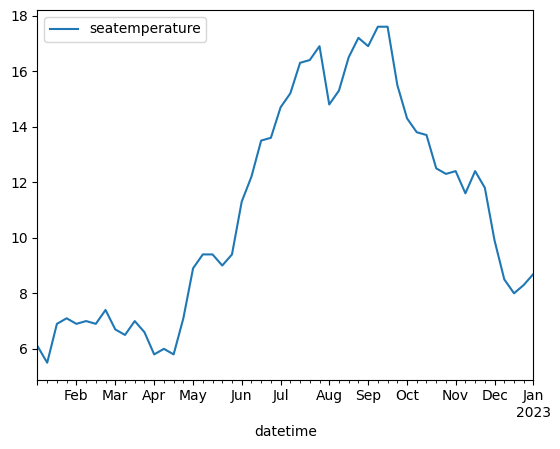

In [29]:
#plot seaTemperature
df_35297.plot(x='datetime', y='seatemperature')

In [34]:

spark.createDataFrame(df_35297).write.format("org.apache.spark.sql.cassandra")\
.options(table="id_35297", keyspace="fish_data").mode("append").save()

In [35]:
spark.read.format("org.apache.spark.sql.cassandra").options(table="id_35297", keyspace="fish_data").load().show()

+-------------------+------------------+-------------+-----------------+---------------+--------------+
|           datetime|avgadultfemalelice|avgmobilelice|avgstationarylice|hasreportedlice|seatemperature|
+-------------------+------------------+-------------+-----------------+---------------+--------------+
|2022-01-09 00:00:00|              0.05|         0.14|             0.05|           true|           6.1|
|2022-03-13 00:00:00|              0.14|         0.32|             0.04|           true|           6.5|
|2022-07-03 00:00:00|              0.11|         0.34|             0.51|           true|          14.7|
|2022-05-15 00:00:00|              0.04|         0.66|             0.24|           true|           9.4|
|2022-05-01 00:00:00|              0.02|         0.18|              0.1|           true|           8.9|
|2022-09-25 00:00:00|              0.38|         0.45|              0.0|           true|          15.5|
|2022-08-28 00:00:00|              0.35|          0.4|          

### Inserting the weather data from Frost

In [ ]:
from frost_credentials.credentials import ID
import requests
client_id = ID['client_id']
client_secret = ID['client_secret']

In [ ]:
id = "SN65310"

In [ ]:
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': f'{id}',
    'elements': 'mean(air_temperature P1D),\
        sum(precipitation_amount P1D),\
        mean(wind_speed P1D),\
        mean(relative_humidity P1D),\
        mean(seaTemperature P1D),)',
    'referencetime': '2021-01-01/2022-01-01'}
r = requests.get(endpoint, parameters, auth=(client_id,''))

json = r.json()

if r.status_code == 200:
    obs_data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

In [ ]:
obs_data

In [ ]:
import pandas as pd

In [ ]:
# This will return a Dataframe with all of the observations in a table format
df_total = pd.DataFrame()
for i in range(len(obs_data)):
    row = pd.DataFrame(obs_data[i]['observations'])
    row['referenceTime'] = obs_data[i]['referenceTime']
    row['sourceId'] = obs_data[i]['sourceId']
    df_total = pd.concat([df_total, row])

In [ ]:
# These additional columns will be kept
columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df = df_total[columns].copy()
# Convert the time value to something Python understands
df['referenceTime'] = pd.to_datetime(df['referenceTime'])

In [ ]:
print(df.shape)
df.head()

In [ ]:
#Plot each of the unique elements from elementId, where x is the referenceTime and y is the value
import matplotlib.pyplot as plt
import seaborn as sns

for element in df['elementId'].unique():
    df_element = df[df['elementId'] == element]
    plt.figure(figsize=(15,5))
    sns.lineplot(x='referenceTime', y='value', data=df_element)
    plt.title(element)
    plt.show()